In [70]:
library(tidyverse)
library(umap)

# Custom package
library(rutils)

In [71]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [72]:
i <- 1

In [73]:
matrisome_df <- load_matrisome_df(matrisome_path)

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)


In [74]:
seed = 123

# Load and filter survival data

In [75]:
event_code <- list("Alive" = 0, "Dead" = 1)
covariate_cols <- c("figo_stage", "age_at_diagnosis", "race", "ethnicity")
dep_cols <- c("vital_status", "survival_time")
figo_map_df <- tibble(
    roman_num = c("I", "II", "III", "IV"),
    figo_code = c('1', '2', '3', '4')
)

In [76]:
# survival_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/survival_data.tsv"))
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[i], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
filtered_survival_df <- survival_df %>%
    dplyr::select(one_of(c("sample_name", dep_cols, covariate_cols))) %>%
    dplyr::filter(rowSums(is.na(.)) == 0) %>%
    dplyr::mutate(
        figo_rn = str_extract(figo_stage, "IV|III|II|I")
    ) %>%
    dplyr::inner_join(figo_map_df, by = c("figo_rn" = "roman_num")) %>%
    dplyr::select(-c(figo_rn, figo_stage)) %>%
    dplyr::rename(figo_stage = figo_code) %>%
    # Convert categorical columns to one-hot to prep for other analyses
    bind_cols(to_one_hot(., "race")) %>%
    bind_cols(to_one_hot(., "ethnicity")) %>%
    dplyr::select(c("sample_name", "figo_stage"), everything(), -c("race", "ethnicity", "vital_status", "survival_time"))

Parsed with column specification:
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)


# Load normalized matrisome count data

In [77]:
norm_matrisome_counts <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/norm_matrisome_counts.tsv")) %>%
    column_to_rownames(var = "geneID") %>%
    as.matrix()

# Match up columns of counts with rows of survival data & only include samples present in survival data
norm_matrisome_survival_counts <- norm_matrisome_counts[, filtered_survival_df$sample_name]

Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character()
)
See spec(...) for full column specifications.


In [78]:
all(rownames(t(norm_matrisome_survival_counts)) == filtered_survival_df$sample_name)

[1] TRUE

# Combine filtered survival data and normalized count data

In [79]:
joined_df <- filtered_survival_df %>%
    inner_join(
        as_tibble(t(norm_matrisome_survival_counts), rownames = "sample_name"),
        by = "sample_name"
    )
nrow(joined_df)
head(joined_df)

# Some genes contain the '-' symbol, which affects formulae
colnames(joined_df) <- gsub("-", "_", colnames(joined_df))

[1] 255

sample_name,figo_stage,age_at_diagnosis,race_american_indian_or_alaska_native,race_asian,race_black_or_african_american,race_native_hawaiian_or_other_pacific_islander,race_not_reported,race_white,ethnicity_hispanic_or_latino,⋯,PIK3IP1,C1QTNF2,PCSK5,ANXA1,HGF,VWA2,FGF3,POSTN,NTF3,S100A6
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-C5-A1BF-01B-11R-A13Y-07,1,16975,0,0,0,0,0,1,0,⋯,9.013453,8.190325,9.503647,14.07799,6.569726,7.315604,4.602649,12.062300,5.649441,16.55841
TCGA-MU-A51Y-01A-11R-A26T-07,2,10199,0,0,0,0,0,1,0,⋯,12.208410,8.172899,10.515388,16.88600,7.384140,7.366949,4.890169,11.011959,5.406776,14.76108
TCGA-EK-A2RM-01A-21R-A18M-07,1,14842,0,0,0,0,0,1,0,⋯,10.854224,6.581217,8.437154,15.81626,7.644559,6.406766,4.998296,11.731128,6.028879,17.11959
TCGA-Q1-A73P-01A-11R-A32P-07,1,16450,0,0,0,0,0,1,0,⋯,10.854487,5.629541,9.602922,14.17475,6.987468,6.731154,4.602649,9.293089,4.893018,16.64949
TCGA-C5-A8YT-01A-11R-A37O-07,1,13253,0,0,0,0,0,1,0,⋯,9.453187,6.398956,12.288955,13.39633,10.228758,8.542025,4.602649,11.765396,5.318924,13.55632
TCGA-C5-A2LZ-01A-11R-A213-07,3,24059,0,0,0,0,0,1,0,⋯,11.492135,7.426145,9.480199,15.92715,6.010764,7.405245,4.602649,7.506731,5.423416,14.73802


In [80]:
res_umap <- umap(joined_df[-c(1, 2)], random_state = seed)

In [81]:
colnames(res_umap$layout) <- c("x1", "x2")
umap_df <- res_umap$layout %>%
    as_tibble() %>%
    bind_cols(joined_df[c("sample_name", "figo_stage")]) %>%
    dplyr::select(c("sample_name", "figo_stage"), everything())

Saving 6.67 x 6.67 in image


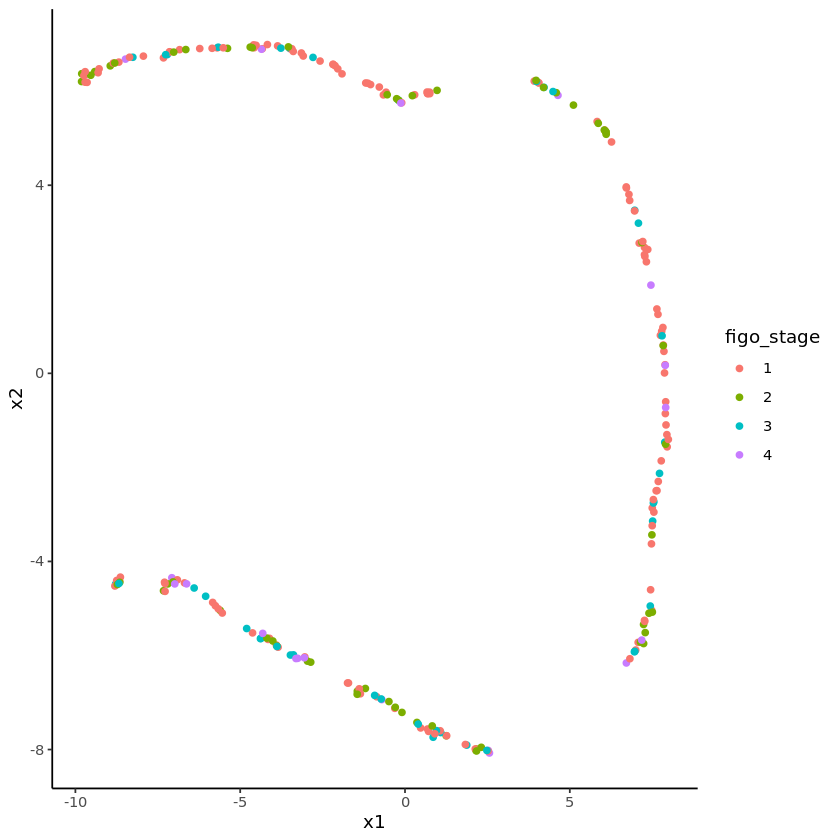

In [83]:
plt <- ggplot(umap_df) +
    geom_point(aes(x = x1, y = x2, color = figo_stage)) +
    theme_classic()
plt
ggsave(filename = paste0(dirs$figures_dir, "/", unified_dsets[i], "_figo_umap.png"), last_plot())